In [1]:
import os

from joblib import Parallel, delayed
import qiime2
import biom
import pandas as pd
import seaborn as sns
from qiime2.plugins import feature_table
from qiime2.plugins import taxa
import matplotlib.pyplot as plt
from collections import Counter

from q2_quality_control._evaluate_taxonomy import _evaluate_taxonomy
from q2_quality_control._utilities import (
    _evaluate_composition, _compute_per_level_accuracy, _match_samples_by_index, _drop_nans_zeros)

%matplotlib inline

In [2]:
def _calc_error_rate(exp_taxa, obs_taxa, table):
    # calculate the error rate
    assert set(exp_taxa.index) == set(obs_taxa.index)
    errors = [0]*7
    total = 0
    for _id in exp_taxa.index:
        exp_taxon = exp_taxa[_id].split(';')
        obs_taxon = obs_taxa[_id].split(';')
        num_reads = int(table[_id])
        total += num_reads
        for level in range(7):
            if exp_taxon[:level+1] != obs_taxon[:level+1]:
                errors[level] += num_reads
    
    df = {'level': range(1,8), 'reads': [total]*7, 'errors': errors}
    return pd.DataFrame(df)

def _eval_for_class_weights(
    cw, type_dir, expected_dir, fns, frequencies_dir):
    er_results = pd.DataFrame()
    if cw == sample_type:
        return er_results

    cw_dir = os.path.join(type_dir, cw)
    # evaluate taxonomy
    for fn in fns:
        if fn in ['log', 'log_missed']:
            continue
        sample, _ = os.path.splitext(fn)

        # load data
        exp_taxa_fp = os.path.join(expected_dir, fn)
        exp_taxa = qiime2.Artifact.load(exp_taxa_fp).view(pd.Series)
        obs_taxa_fp = os.path.join(cw_dir, fn)
        obs_taxa = qiime2.Artifact.load(obs_taxa_fp).view(pd.Series)
        table_fp = os.path.join(frequencies_dir, fn)
        table = qiime2.Artifact.load(table_fp).view(pd.DataFrame)
        
        results = _calc_error_rate(exp_taxa, obs_taxa, table)
        results['class weights'] = cw
        results['sample type'] = sample_type
        results['sample'] = sample

        er_results = pd.concat([er_results, results])

    return er_results

In [3]:
project_dir = os.path.expandvars('/Users/benkaehler/Data/empo_3/')
sample_types = ['animal-corpus', 'animal-distal-gut', 'animal-proximal-gut',
                'animal-secretion', 'animal-surface',  
                'plant-corpus', 'plant-rhizosphere',
                'sediment-non-saline', 'sediment-saline', 
                'soil-non-saline', 'surface-non-saline',
                'surface-saline', 'water-non-saline', 'water-saline']
class_weights = ['animal-corpus', 'animal-distal-gut', 'animal-proximal-gut',
                 'animal-secretion', 'animal-surface',  
                 'plant-corpus', 'plant-rhizosphere',
                 'sediment-non-saline', 'sediment-saline', 
                 'soil-non-saline', 'surface-non-saline',
                 'surface-saline', 'water-non-saline', 'water-saline',
                 'average', 'bespoke70', 'uniform70', ]

# Evaluate taxa

In [4]:
er_results = pd.DataFrame()

for sample_type in sample_types:
    type_dir = os.path.join(project_dir, sample_type, 'results')
    expected_dir = os.path.join(type_dir, 'expected')
    fns = os.listdir(expected_dir)
    frequencies_dir = os.path.join(type_dir, 'abundance')

#    results = []
#    for cw in class_weights:
#        results.append(_eval_for_class_weights(
#            cw, type_dir, expected_dir, fns, frequencies_dir))
    
    results = Parallel(n_jobs=6, verbose=50, batch_size=1)(
        delayed(_eval_for_class_weights)(
            cw, type_dir, expected_dir, fns, 
            frequencies_dir) 
        for cw in class_weights)

    er_results = pd.concat([er_results] + list(results))
    er_results.to_csv(os.path.join(project_dir, 'eval_taxa_er.tsv'), sep='\t')

[Parallel(n_jobs=6)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=6)]: Done   2 tasks      | elapsed:  6.3min
[Parallel(n_jobs=6)]: Done   3 tasks      | elapsed:  6.3min
[Parallel(n_jobs=6)]: Done   4 tasks      | elapsed:  6.3min
[Parallel(n_jobs=6)]: Done   5 tasks      | elapsed:  6.3min
[Parallel(n_jobs=6)]: Done   6 tasks      | elapsed:  6.3min
[Parallel(n_jobs=6)]: Done   7 out of  17 | elapsed:  6.3min remaining:  9.0min
[Parallel(n_jobs=6)]: Done   8 out of  17 | elapsed: 12.2min remaining: 13.7min
[Parallel(n_jobs=6)]: Done   9 out of  17 | elapsed: 12.2min remaining: 10.8min
[Parallel(n_jobs=6)]: Done  10 out of  17 | elapsed: 12.2min remaining:  8.5min
[Parallel(n_jobs=6)]: Done  11 out of  17 | elapsed: 12.2min remaining:  6.7min
[Parallel(n_jobs=6)]: Done  12 out of  17 | elapsed: 12.2min remaining:  5.1min
[Parallel(n_jobs=6)]: Done  13 out of  17 | elapsed: 12.2min remaining:  3.8min
[Parallel(n_jobs=6)]: Done  14 out of  17 | elapsed: 17.5min remaining:  3

[Parallel(n_jobs=6)]: Done  14 out of  17 | elapsed: 15.4min remaining:  3.3min
[Parallel(n_jobs=6)]: Done  15 out of  17 | elapsed: 15.4min remaining:  2.1min
[Parallel(n_jobs=6)]: Done  17 out of  17 | elapsed: 15.4min remaining:    0.0s
[Parallel(n_jobs=6)]: Done  17 out of  17 | elapsed: 15.4min finished
[Parallel(n_jobs=6)]: Done   1 tasks      | elapsed:  2.0min
[Parallel(n_jobs=6)]: Done   2 tasks      | elapsed:  2.0min
[Parallel(n_jobs=6)]: Done   3 tasks      | elapsed:  2.0min
[Parallel(n_jobs=6)]: Done   4 tasks      | elapsed:  2.0min
[Parallel(n_jobs=6)]: Done   5 tasks      | elapsed:  2.0min
[Parallel(n_jobs=6)]: Done   6 tasks      | elapsed:  2.0min
[Parallel(n_jobs=6)]: Done   7 out of  17 | elapsed:  2.0min remaining:  2.8min
[Parallel(n_jobs=6)]: Done   8 out of  17 | elapsed:  3.6min remaining:  4.1min
[Parallel(n_jobs=6)]: Done   9 out of  17 | elapsed:  3.7min remaining:  3.3min
[Parallel(n_jobs=6)]: Done  10 out of  17 | elapsed:  3.7min remaining:  2.6min
[Par

[Parallel(n_jobs=6)]: Done  10 out of  17 | elapsed:  8.1min remaining:  5.7min
[Parallel(n_jobs=6)]: Done  11 out of  17 | elapsed:  8.1min remaining:  4.4min
[Parallel(n_jobs=6)]: Done  12 out of  17 | elapsed:  8.1min remaining:  3.4min
[Parallel(n_jobs=6)]: Done  13 out of  17 | elapsed:  8.1min remaining:  2.5min
[Parallel(n_jobs=6)]: Done  14 out of  17 | elapsed: 11.1min remaining:  2.4min
[Parallel(n_jobs=6)]: Done  15 out of  17 | elapsed: 11.1min remaining:  1.5min
[Parallel(n_jobs=6)]: Done  17 out of  17 | elapsed: 11.1min remaining:    0.0s
[Parallel(n_jobs=6)]: Done  17 out of  17 | elapsed: 11.1min finished


In [5]:
er_results.to_csv(os.path.join(project_dir, 'eval_taxa_er.tsv'), sep='\t')

In [14]:
er_results

F-measure  Precision    Recall  Unnamed: 0      class weights  level  \
6     0.776232   0.953447  0.654569         6.0  animal-distal-gut      7   
20    0.805746   0.843200  0.771477         6.0  animal-distal-gut      7   
34    0.820302   0.834004  0.807043         6.0  animal-distal-gut      7   
48    0.756090   0.811683  0.707625         6.0  animal-distal-gut      7   
62    0.690795   0.726612  0.658343         6.0  animal-distal-gut      7   
76    0.680628   0.724977  0.641392         6.0  animal-distal-gut      7   
90    0.938124   0.959184  0.917969         6.0  animal-distal-gut      7   
104   0.973878   0.989116  0.959103         6.0  animal-distal-gut      7   
118   0.793263   0.848164  0.745037         6.0  animal-distal-gut      7   
132   0.935468   0.943827  0.927255         6.0  animal-distal-gut      7   
146   0.808791   0.910891  0.727273         6.0  animal-distal-gut      7   
160   0.820000   0.872340  0.773585         6.0  animal-distal-gut      7   
174   0.743102   0.792955  0.699147         6.0  animal-distal-gut      7   
188   0.508571   0.871329  0.359078         6.0  animal-distal-gut      7   
202   0.884087   0.910102  0.859519         6.0  animal-distal-gut      7   
216   0.507869   0.521566  0.494873         6.0  animal-distal-gut      7   
230   0.077982   0.347916  0.043912         6.0  animal-distal-gut      7   
244   0.909357   0.917095  0.901748         6.0  animal-distal-gut      7   
258   0.852826   0.901002  0.809540         6.0  animal-distal-gut      7   
272   0.848695   0.876505  0.822596         6.0  animal-distal-gut      7   
286   0.500861   0.527455  0.476819         6.0  animal-distal-gut      7   
300   0.768077   0.844910  0.704052         6.0  animal-distal-gut      7   
314   0.869565   0.909091  0.833333         6.0  animal-distal-gut      7   
328   0.806959   0.869996  0.752439         6.0  animal-distal-gut      7   
342   0.902396   0.932730  0.873973         6.0  animal-distal-gut      7   
356   0.869438   0.908742  0.833393         6.0  animal-distal-gut      7   
370   0.484456   0.683071  0.375324         6.0  animal-distal-gut      7   
384   0.666667   0.870504  0.540179         6.0  animal-distal-gut      7   
398   0.945691   0.968227  0.924181         6.0  animal-distal-gut      7   
412   0.947368   1.000000  0.900000         6.0  animal-distal-gut      7   
..         ...        ...       ...         ...                ...    ...   
6     0.819323   0.868747  0.775220         NaN          uniform70      7   
6     0.735915   0.818744  0.668305         NaN          uniform70      7   
6     0.848364   0.905369  0.798112         NaN          uniform70      7   
6     0.801219   0.847075  0.760072         NaN          uniform70      7   
6     0.863154   0.899318  0.829787         NaN          uniform70      7   
6     0.828569   0.874542  0.787188         NaN          uniform70      7   
6     0.761177   0.806319  0.720822         NaN          uniform70      7   
6     0.855445   0.894231  0.819884         NaN          uniform70      7   
6     0.765359   0.851304  0.695177         NaN          uniform70      7   
6     0.708999   0.799743  0.636750         NaN          uniform70      7   
6     0.766535   0.829907  0.712154         NaN          uniform70      7   
6     0.827151   0.871119  0.787408         NaN          uniform70      7   
6     0.838880   0.886996  0.795715         NaN          uniform70      7   
6     0.849121   0.902186  0.801953         NaN          uniform70      7   
6     0.901891   0.936643  0.869626         NaN          uniform70      7   
6     0.813485   0.861414  0.770609         NaN          uniform70      7   
6     0.787950   0.849358  0.734823         NaN          uniform70      7   
6     0.625473   0.777429  0.523207         NaN          uniform70      7   
6     0.818154   0.872162  0.770444         NaN          uniform70      7   
6     0.869761   0.925616  0.820263         NaN          uniform70      7   
6

In [11]:
prf_results = prf_results[(prf_results['class weights'] != 'bespoke92') & 
                          (prf_results['class weights'] != 'uniform92')]

In [12]:
palette = "Set1"

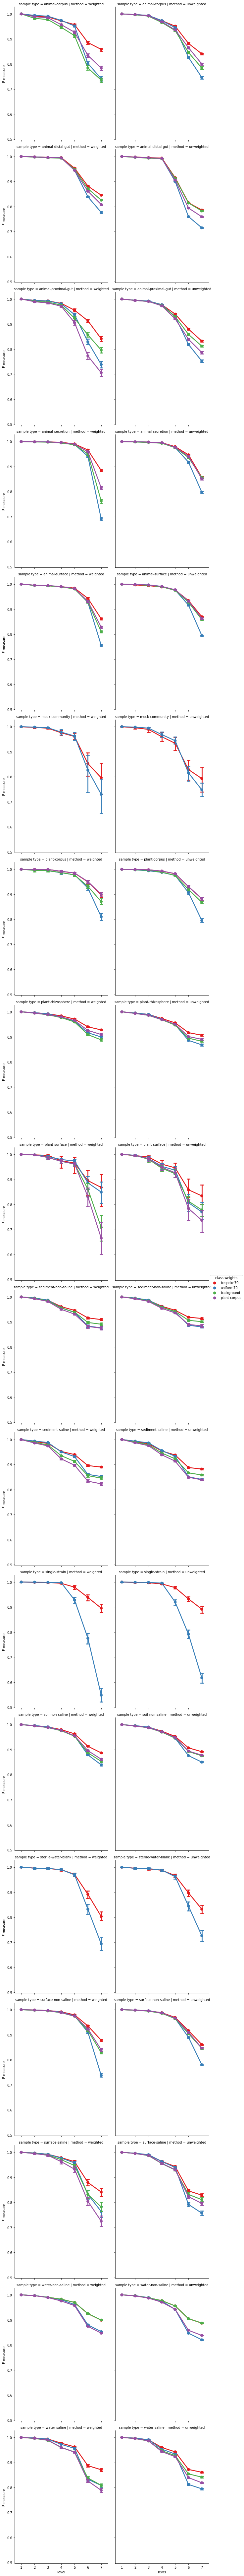

In [13]:
g = sns.factorplot(x="level", y="F-measure", hue="class weights", col="method", row="sample type", data=prf_results,
                   capsize=.2, palette=palette, size=6, aspect=.75)


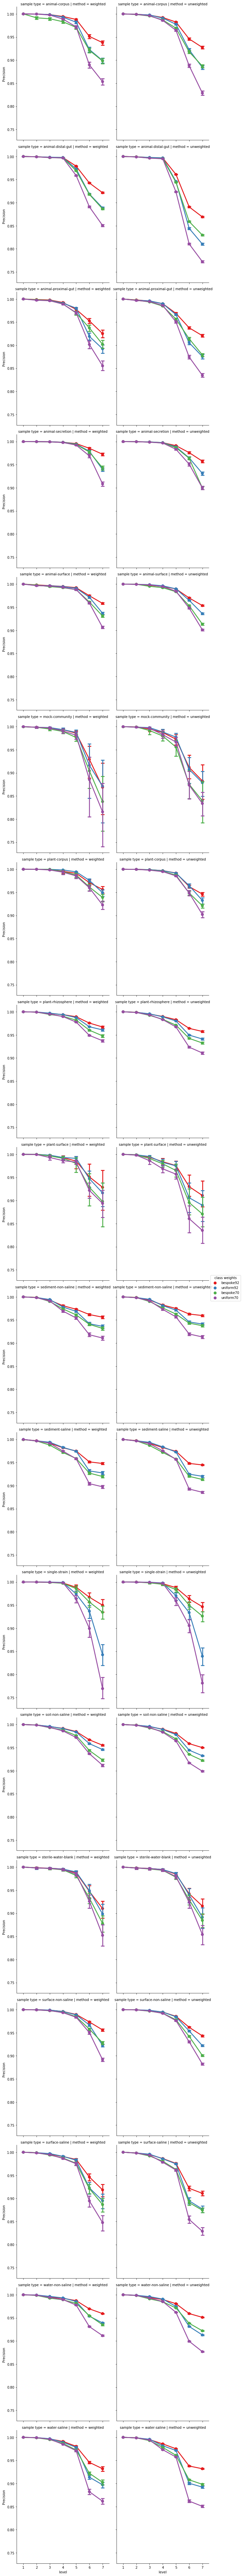

In [11]:
g = sns.factorplot(x="level", y="Precision", hue="class weights", col="method", row="sample type", data=prf_results,
                   capsize=.2, palette=palette, size=6, aspect=.75)


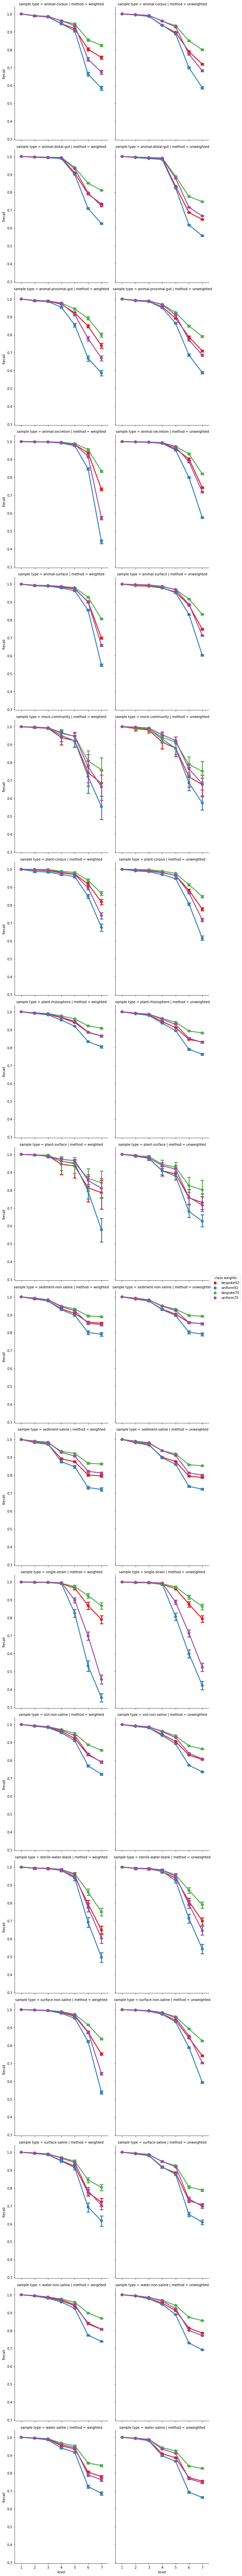

In [12]:
g = sns.factorplot(x="level", y="Recall", hue="class weights", col="method", row="sample type", data=prf_results,
                   capsize=.2, palette=palette, size=6, aspect=.75)


# Evaluate composition

In [13]:
eval_comp_results


sample  level  Observed Taxa  Observed / Expected Taxa       TAR  \
0   Frequency      1              1                  1.000000  1.000000   
1   Frequency      2              9                  1.125000  1.000000   
2   Frequency      3             18                  1.200000  1.000000   
3   Frequency      4             42                  1.235294  0.970588   
4   Frequency      5             61                  1.355556  0.911111   
5   Frequency      6             90                  1.578947  0.842105   
6   Frequency      7            104                  1.575758  0.727273   
0   Frequency      1              2                  1.000000  1.000000   
1   Frequency      2             20                  1.000000  0.950000   
2   Frequency      3             52                  1.083333  0.979167   
3   Frequency      4            111                  1.132653  0.989796   
4   Frequency      5            212                  1.225434  0.988439   
5   Frequency      6            384                  1.432836  0.914179   
6   Frequency      7            446                  1.471947  0.848185   
0   Frequency      1              1                  1.000000  1.000000   
1   Frequency      2             12                  1.090909  1.000000   
2   Frequency      3             24                  1.142857  1.000000   
3   Frequency      4             45                  1.184211  1.000000   
4   Frequency      5             74                  1.213115  0.950820   
5   Frequency      6            123                  1.268041  0.896907   
6   Frequency      7            161                  1.319672  0.786885   
0   Frequency      1              2                  1.000000  1.000000   
1   Frequency      2             30                  1.034483  1.000000   
2   Frequency      3             79                  1.097222  0.986111   
3   Frequency      4            150                  1.111111  0.970370   
4   Frequency      5            236                  1.204082  0.969388   
5   Frequency      6            383                  1.434457  0.925094   
6   Frequency      7            413                  1.480287  0.885305   
0   Frequency      1              2                  1.000000  1.000000   
1   Frequency      2             17                  1.062500  1.000000   
..        ...    ...            ...                       ...       ...   
5   Frequency      6            203                  2.136842  0.936842   
6   Frequency      7            231                  2.333333  0.929293   
0   Frequency      1              1                  1.000000  1.000000   
1   Frequency      2              8                  1.142857  1.000000   
2   Frequency      3             14                  1.166667  1.000000   
3   Frequency      4             27                  1.350000  1.000000   
4   Frequency      5             42                  1.354839  1.000000   
5   Frequency      6             73                  1.586957  0.934783   
6   Frequency      7             87                  1.740000  0.900000   
0   Frequency      1              2                  1.000000  1.000000   
1   Frequency      2             17                  1.133333  1.000000   
2   Frequency      3             36                  1.241379  1.000000   
3   Frequency      4             65                  1.226415  1.000000   
4   Frequency      5            107                  1.389610  1.000000   
5   Frequency      6            222                  2.074766  0.943925   
6   Frequency      7            252                  2.311927  0.917431   
0   Frequency      1              3                  1.500000  1.000000   
1   Frequency      2             59                  1.053571  0.982143   
2   Frequency      3            176                  1.060241  0.987952   
3   Frequency      4            335                  1.080645  0.987097   
4   Frequency      5            550                  1.157895  0.985263   
5   Frequency      6           1

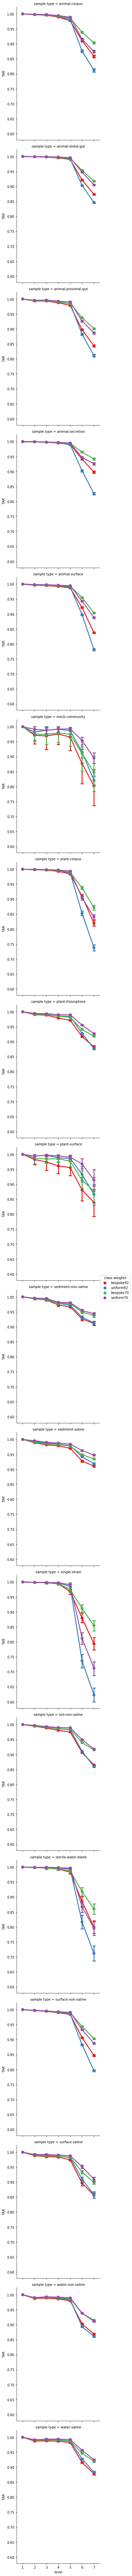

In [14]:
g = sns.factorplot(x="level", y="TAR", hue="class weights", row="sample type", data=eval_comp_results,
                   capsize=.2, palette=palette, size=6, aspect=.75)


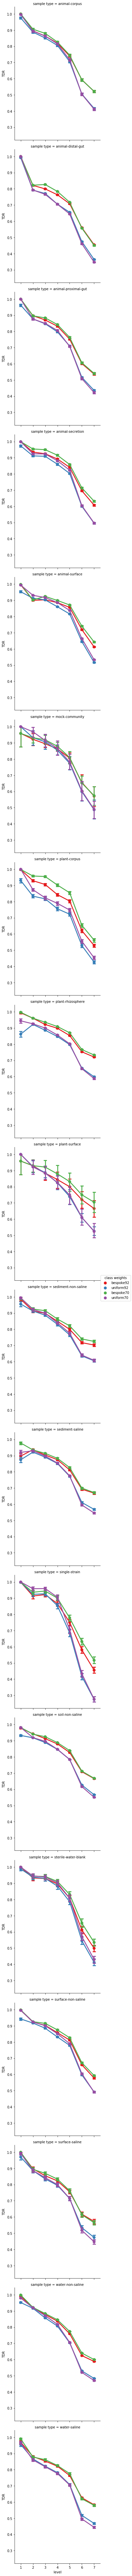

In [15]:
g = sns.factorplot(x="level", y="TDR", hue="class weights", row="sample type", data=eval_comp_results,
                   capsize=.2, palette=palette, size=6, aspect=.75)


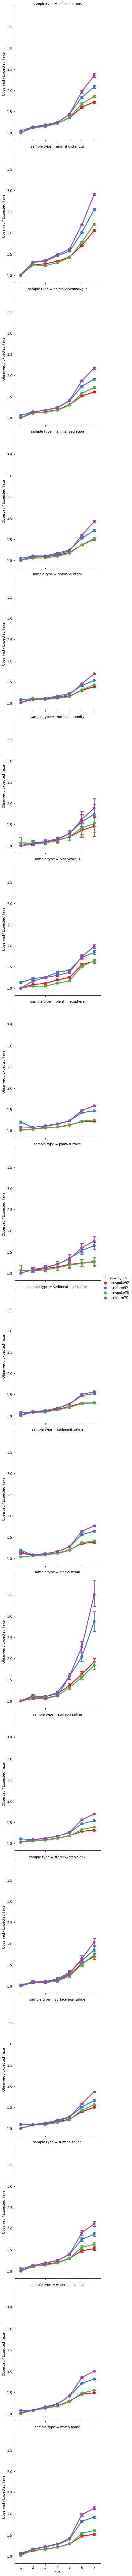

In [16]:
g = sns.factorplot(x="level", y="Observed / Expected Taxa", hue="class weights", row="sample type", data=eval_comp_results,
                   capsize=.2, palette=palette, size=6, aspect=.75)


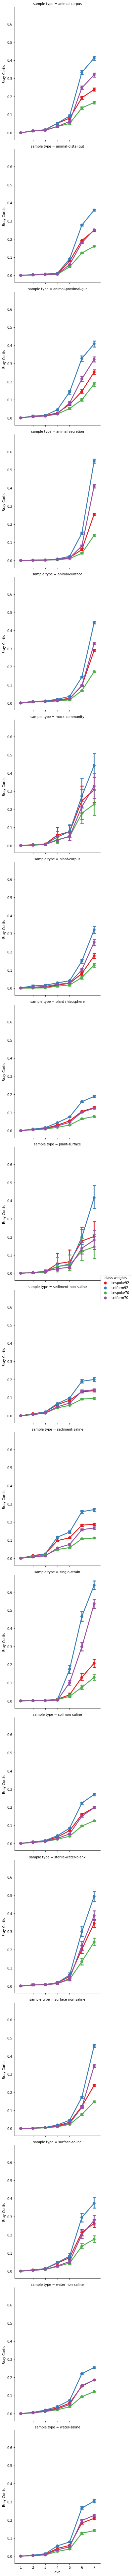

In [17]:
g = sns.factorplot(x="level", y="Bray-Curtis", hue="class weights", row="sample type", data=eval_comp_results,
                   capsize=.2, palette=palette, size=6, aspect=.75)


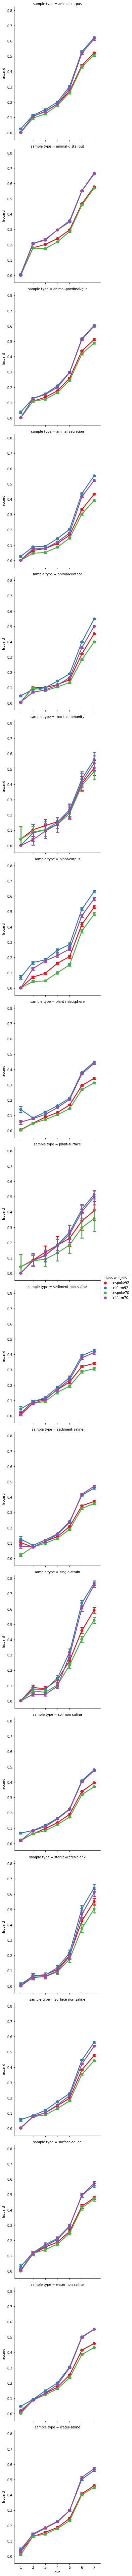

In [18]:
g = sns.factorplot(x="level", y="Jaccard", hue="class weights", row="sample type", data=eval_comp_results,
                   capsize=.2, palette=palette, size=6, aspect=.75)


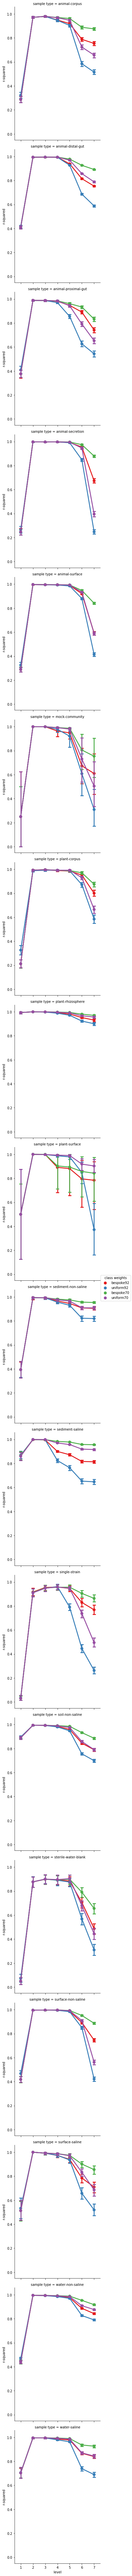

In [19]:
g = sns.factorplot(x="level", y="r-squared", hue="class weights", row="sample type", data=eval_comp_results,
                   capsize=.2, palette=palette, size=6, aspect=.75)
